# Homework 2, Problem 5

In this problem we look at weather and how it impacts trading on the New York stock enchange. Complete this notebook and keep it in a homework 2 repo. Submit the repo link though the blackboard.

**You are free to add implmentation or markdown cells to make your notebook clearer!!**

## Data:

The following two datasets are our focus

* Weather data [NOAA-GHCN](https://registry.opendata.aws/noaa-ghcn/)
* Stock Exchange Data [Yahoo Finance](https://finance.yahoo.com/quote/%5ENYA/history?ltr=1) 



## Part 1: Download The Weather Data




Download a year of weather data.

The Raw GHCN files don't have column headers, so we manually add them in. It's safer to at this point read in everything as an object & then parse to the correct type once you extract the variables you're interested in. 
This information can be found in https://docs.opendata.aws/noaa-ghcn-pds/readme.html

In [32]:
import urllib 

import pandas as pd
import numpy as np
import dask.dataframe as dd
import dask.bag as db
import dask.diagnostics as dg
import matplotlib.pyplot as plt

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense,Dropout


Using TensorFlow backend.


We're using Dask for the lazy evaluation properties (it will only try to run the computations at the end, hopefully after the data has been filtered down) because the dataset is very large. We set the storage options to `anon=True` because this data is public. Otherwise this kwarg is where we'd pass in the AWS authorization keys. 

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Let's load in the data for 1992
YEAR = 1992

names = ['ID', 'DATE', 'ELEMENT', 'DATA_VALUE', 'M-FLAG', 'Q-FLAG', 'S-FLAG', 'OBS-TIME']
ds = dd.read_csv(f's3://noaa-ghcn-pds/csv/{YEAR}.csv', storage_options={'anon':True},  names=names, memory_map=False, 
                  dtype={'DATA_VALUE':'object'}, parse_dates=['DATE', 'OBS-TIME'])

In [4]:
# You can check the data
print(ds.columns)
print(ds.dtypes)

Index(['ID', 'DATE', 'ELEMENT', 'DATA_VALUE', 'M-FLAG', 'Q-FLAG', 'S-FLAG',
       'OBS-TIME'],
      dtype='object')
ID                    object
DATE          datetime64[ns]
ELEMENT               object
DATA_VALUE            object
M-FLAG                object
Q-FLAG                object
S-FLAG                object
OBS-TIME              object
dtype: object


In [5]:
# Print out the first few rows
ds.head()

,ID,DATE,ELEMENT,DATA_VALUE,M-FLAG,Q-FLAG,S-FLAG,OBS-TIME
0,CA002303986,1992-01-01,TMAX,-70,NaN,NaN,C,NaN
1,CA002303986,1992-01-01,TMIN,-240,NaN,NaN,C,NaN
2,CA002303986,1992-01-01,PRCP,4,NaN,NaN,C,NaN
3,CA002303986,1992-01-01,SNOW,4,NaN,NaN,C,NaN
4,CA002303986,1992-01-01,SNWD,420,NaN,NaN,C,NaN


Now we want to parse out the station ID list. We are using [pandas.read_fwf](https://pandas.pydata.org/pandas-docs/version/0.23.4/generated/pandas.read_fwf.html#pandas.read_fwf) because this file is a fixed format width table rather than a csv file. 
We explicitly pass in the extents of the fixed width field because Pandas has trouble inferring what belongs in the `STATE` column versus in the `NAME` column. We obtained these extents from the readme https://docs.opendata.aws/noaa-ghcn-pds/readme.html

In [0]:
# {column name:extents of the fixed-width fields}
columns = {"ID": (0,11), "LATITUDE": (12, 20), "LONGITUDE": (21, 30), "ELEVATION": (31, 37),"STATE": (38, 40),
           "NAME": (41, 71), "GSN FLAG": (72, 75), "HCN/CRN FLAG": (76, 79),"WMO ID": (80, 85)}

In [0]:
# df = pd.read_fwf("http://noaa-ghcn-pds.s3.amazonaws.com/ghcnd-stations.txt", 
#                     colspecs=list(columns.values()), names=list(columns.keys()))

df = pd.read_fwf("https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/ghcnd-stations.txt", 
                    colspecs=list(columns.values()), names=list(columns.keys()))


In [11]:
# You should be looking for those in the New York area like Central Park, JFK, LGA and Newark airport.
NYNJ = df[df['STATE'].isin(['NY', 'NJ'])]
NYNJ.head()

,ID,LATITUDE,LONGITUDE,ELEVATION,STATE,NAME,GSN FLAG,HCN/CRN FLAG,WMO ID
73674,US1NJAT0001,39.5483,-74.8671,31.4,NJ,BUENA VISTA TWP 2.6 NNE,NaN,NaN,NaN
73675,US1NJAT0002,39.5565,-74.8048,14.0,NJ,FOLSOM 3.2 SE,NaN,NaN,NaN
73676,US1NJAT0003,39.4747,-74.7107,5.5,NJ,HAMILTON TWP 2.1 SE,NaN,NaN,NaN
73677,US1NJAT0005,39.6404,-74.8261,29.9,NJ,HAMMONTON 3.3 WSW,NaN,NaN,NaN
73678,US1NJAT0009,39.3346,-74.5759,5.8,NJ,LINWOOD 0.7 SSW,NaN,NaN,NaN


Central Park is coded in shorthand, so we used the NOAA web portal to look up the correct ID
https://www.ncdc.noaa.gov/cdo-web/datasets/GHCND/stations/GHCND:USW00094728/detail

In [12]:
NYNJ[NYNJ['ID'].str.contains('USW00094728')]

,ID,LATITUDE,LONGITUDE,ELEVATION,STATE,NAME,GSN FLAG,HCN/CRN FLAG,WMO ID
114226,USW00094728,40.7789,-73.9692,39.6,NY,NEW YORK CNTRL PK TWR,NaN,HCN,72506.0


In [13]:
# Airports + Central Park
apcp = NYNJ[NYNJ['NAME'].str.endswith('AP') | NYNJ['ID'].str.contains('USW00094728')]
apcp.head()

,ID,LATITUDE,LONGITUDE,ELEVATION,STATE,NAME,GSN FLAG,HCN/CRN FLAG,WMO ID
100219,USC00305840,43.1139,-78.9353,179.2,NY,NIAGARA FALLS INTL AP,NaN,NaN,NaN
112764,USW00004724,43.1072,-78.9453,178.3,NY,NIAGARA FALLS INTL AP,NaN,NaN,NaN
112769,USW00004742,44.6500,-73.4667,71.9,NY,PLATTSBURGH INTL AP,NaN,NaN,NaN
112775,USW00004781,40.7939,-73.1017,25.6,NY,ISLIP LI MACARTHUR AP,NaN,NaN,72505.0
112779,USW00004789,41.5092,-74.2650,111.3,NY,MONTGOMERY ORANGE AP,NaN,NaN,NaN


What we're interested in is the IDs, which we will use for our dataset to obtain only the stations of interest. We are going to join our two dataframes on the ID column so that we have all the information in every row.  We are removing the flags since they have neither computational nor necessary identification information. 

we do not use `.compute()` to resolve the computation because it's better to hold off until the completetion of feature selection and engineering described below. If you'd like a fully computed dataframe, the code is 
```python


In [0]:
nyds = ds.merge(apcp[['ID', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'STATE', 'NAME']], on='ID')

In [21]:
nyds.head()

,ID,DATE,ELEMENT,DATA_VALUE,M-FLAG,Q-FLAG,S-FLAG,OBS-TIME,LATITUDE,LONGITUDE,ELEVATION,STATE,NAME
0,USW00094790,1992-01-01,TMAX,61,NaN,NaN,0,2400,43.9922,-76.0217,96.9,NY,WATERTOWN INTL AP
1,USW00094790,1992-01-01,TMIN,-133,NaN,NaN,0,2400,43.9922,-76.0217,96.9,NY,WATERTOWN INTL AP
2,USW00094790,1992-01-01,PRCP,0,NaN,NaN,0,2400,43.9922,-76.0217,96.9,NY,WATERTOWN INTL AP
3,USW00094790,1992-01-01,SNOW,0,NaN,NaN,0,NaN,43.9922,-76.0217,96.9,NY,WATERTOWN INTL AP
4,USW00094790,1992-01-01,SNWD,0,NaN,NaN,0,NaN,43.9922,-76.0217,96.9,NY,WATERTOWN INTL AP


## Part 2: Downoad Stock Price Data

Here the idea is to get the finance data from Yahoo finace.  It's already the right date range in general:

In [0]:
finance_df = pd.read_csv("https://query1.finance.yahoo.com/v7/finance/download/%5ENYA?period1=694224000&period2=725760000&interval=1d&events=history")
finance_df = finance_df.rename(columns={"Date": "DATE"})

In [18]:
finance_df.head()

,DATE,Open,High,Low,Close,Adj Close,Volume
0,1992-01-02,2423.179932,2423.179932,2423.179932,2423.179932,2423.179932,0
1,1992-01-03,2435.659912,2435.659912,2435.659912,2435.659912,2435.659912,0
2,1992-01-06,2430.370117,2430.370117,2430.370117,2430.370117,2430.370117,0
3,1992-01-07,2428.679932,2428.679932,2428.679932,2428.679932,2428.679932,0
4,1992-01-08,2434.389893,2434.389893,2434.389893,2434.389893,2434.389893,0


You can do an inner join for the dates from the financial dataset and the new york weather dataset, to get all your features ready, please do that here:

In [0]:
# your join on dates goes here:
ny_df = nyds.compute()
ny_df["DATE"] = pd.to_datetime(ny_df["DATE"])
finance_df["DATE"] = pd.to_datetime(finance_df["DATE"])

In [0]:
ny_df = pd.pivot_table(ny_df, values='DATA_VALUE', columns=['ELEMENT'], index=['ID', 'DATE'], aggfunc=np.max, fill_value=0)

In [26]:
ny_df[:5]

ELEMENT                ACMH ACSH AWND FMTM PGTM  ... WT15 WT16 WT17 WT18 WT22
ID          DATE                                 ...                         
USC00305840 1992-01-01    0    0    0    0    0  ...    0    0    0    0    0
            1992-01-02    0    0    0    0    0  ...    0    0    0    0    0
            1992-01-03    0    0    0    0    0  ...    0    0    0    0    0
            1992-01-04    0    0    0    0    0  ...    0    0    0    0    0
            1992-01-05    0    0    0    0    0  ...    0    0    0    0    0

[5 rows x 32 columns]

In [0]:
joined_data = pd.merge(ny_df, finance_df, on = 'DATE', how = 'inner')

In [31]:
joined_data.head()

,DATE,ACMH,ACSH,AWND,FMTM,PGTM,PRCP,SNOW,SNWD,TMAX,TMIN,TOBS,TSUN,WDF1,WDFG,WESD,WSF1,WSFG,WT01,WT02,WT03,WT04,WT05,WT06,WT08,WT09,WT11,WT14,WT15,WT16,WT17,WT18,WT22,Open,High,Low,Close,Adj Close,Volume
0,1992-01-02,0,0,0,0,0,0,0,0,67,-17,-6,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2423.179932,2423.179932,2423.179932,2423.179932,2423.179932,0
1,1992-01-02,0,0,20,0,0,0,0,0,100,-44,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2423.179932,2423.179932,2423.179932,2423.179932,2423.179932,0
2,1992-01-02,0,0,0,0,0,0,0,0,133,-22,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,2423.179932,2423.179932,2423.179932,2423.179932,2423.179932,0
3,1992-01-02,100,90,34,2150,2149,0,0,0,83,33,0,0,40,45,0,67,77,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2423.179932,2423.179932,2423.179932,2423.179932,2423.179932,0
4,1992-01-02,100,100,18,1450,2115,0,0,0,94,0,0,0,130,45,0,40,77,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,2423.179932,2423.179932,2423.179932,2423.179932,2423.179932,0


## Part 3: Creating and Selecting Variables

Pull out and encode the various variables listed below and set up these varaibles at least initially in a pandas data frame.

### Weather variables

* raining:
    - 0 - wasn't raining
    - 1 - was raining
* rain intensity:
    - 0 -low
    - 1 - medium
    - 2 - high
* rain duration in hours
* snowing:
    - 0 - wasn't snowing
    - 1 - was snowing
* snow intensity:
    - 0 - low
    1 - medium
    2 - high
* snow duration in hours
* windy:
    - 0 - low
    - 1 - medium
    - 2 - high

### Market Variables 

* Market Open
* Market Close
* Market High
* Market Low
* Market Volume


Make sure you have aligned the data by date in a pandas data frame. Show the counts and the summary stats.

In [0]:
joined_data['HighLow'] = joined_data.High - joined_data.Low

In [72]:
joined_data[:5]

,ACMH,ACSH,AWND,FMTM,PGTM,PRCP,SNOW,SNWD,TMAX,TMIN,TOBS,TSUN,WDF1,WDFG,WESD,WSF1,WSFG,WT01,WT02,WT03,WT04,WT05,WT06,WT08,WT09,WT11,WT14,WT15,WT16,WT17,WT18,WT22,Open,High,Low,Close,Adj Close,Volume,HighLow
0,0,0,0,0,0,0,0,0,67,-17,-6,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2423.179932,2423.179932,2423.179932,2423.179932,2423.179932,0,0.0
1,0,0,20,0,0,0,0,0,100,-44,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2423.179932,2423.179932,2423.179932,2423.179932,2423.179932,0,0.0
2,0,0,0,0,0,0,0,0,133,-22,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,2423.179932,2423.179932,2423.179932,2423.179932,2423.179932,0,0.0
3,100,90,34,2150,2149,0,0,0,83,33,0,0,40,45,0,67,77,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2423.179932,2423.179932,2423.179932,2423.179932,2423.179932,0,0.0
4,100,100,18,1450,2115,0,0,0,94,0,0,0,130,45,0,40,77,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,2423.179932,2423.179932,2423.179932,2423.179932,2423.179932,0,0.0


## Part 4: Feature Engineering

Because we are going to be thinking of this in terms of a simple neural network here (like a dense neural network), extend the data by the input data actually being the past $n$ days ($n$ between 1 and 7). In other words the $X$ input should contain a lag of variables you loaded, but lagged by days from 1 through 7. In other words if it hasn't snowed in the past 7 days you will have attributes $[0,0,0,0,0,0,0]$ for yesterday and the preceeding 8 days of no snow, being "columns" or dimensions in your input data.

One challenge is that for weekend you will not have trading days so you will need to do some data filling. After you "fatten" your data, should see if you need all this data. You should normalize all your input variables so that that have an approximate range between 0 and 1. 

In [0]:
from functools import partial

def lag_function(num_days, x):
    # fill in the code for the lag day here
    return x

lag_one_day = partial(lag_function, 1)
joined_data["market_volatility_lag_one"] = joined_data.apply(lag_one_day, axis=1)

lag_two_days = partial(lag_function, 2)
joined_data["market_volatility_lag_two"] = joined_data.apply(lag_two_days, axis=1)

lag_three_days = partial(lag_function, 3)
joined_data["market_volatility_lag_three"] = joined_data.apply(lag_three_days, axis=1)

lag_four_days = partial(lag_function, 4)
joined_data["market_volatility_lag_four"] = joined_data.apply(lag_four_days, axis=1)

lag_five_days = partial(lag_function, 5)
joined_data["market_volatility_lag_five"] = joined_data.apply(lag_five_days, axis=1)

lag_six_days = partial(lag_function, 6)
joined_data["market_volatility_lag_six"] = joined_data.apply(lag_six_days, axis=1)

lag_seven_days = partial(lag_function, 7)
joined_data["market_volatility_lag_seven"] = joined_data.apply(lag_seven_days, axis=1)


## Part 5: Try out different Models and prediction!

Your goal is to predict the volatility in the market, that is the Market High - Market Low your "Y" value. For convenience create that column. All of the other columns will help create your "X" variables. You can use any of the other variables as predictors. Be careful not use Market High or Market Low as "X" variables!

Since we are doing a regression problem that means that the last neural net activation will probably be linear and the loss should be Mean Squared Error or root mean squared error or mean absolute error.

Try five different models. For each model, please report mse, root mse and mean absolute error.  You can get the training history with:

Record the history with:

`history = model.fit(X, y, validation_split=0.1)`

and get the history for your metrics with:

`history.history`

For more details, see this tutorial: https://machinelearningmastery.com/custom-metrics-deep-learning-keras-python/

Also, please note the above tutorial shows you how to include multiple metrics with keras.

Then try cross validation with the above metrics. 

If you've never done cross validation with keras before, please use: https://machinelearningmastery.com/evaluate-performance-deep-learning-models-keras/

The above tutorial will show you how.

After running cross validation for each of the metrics you should be able to answer the following questions:

Is there overfitting? How do you know?
Why do you think certain models worked well and others not as well? 
How might you improve the model?

In [0]:
def model_one():
  model = Sequential()
  model.add(Dense(64, activation = 'relu'))
  model.add(Dense(1,activation='linear'))
  model.compile(loss = 'mse', optimizer ='adam', metrics = ['mse','accuracy'])
  
  return model

def model_two():
  model = Sequential()
  model.add(Dense(64, activation = 'relu'))
  model.add(Dense(1,activation='sigmoid'))
  model.compile(loss = 'mse', optimizer ='adam', metrics = ['mse','accuracy'])
  
  return model

def model_three():
  model = Sequential()
  model.add(Dense(64, activation = 'relu'))
  model.add(Dense(32, activation = 'relu'))
  model.add(Dense(1,activation='sigmoid'))
  model.compile(loss = 'mse', optimizer ='adam', metrics = ['mse','accuracy'])
  
  return model

def model_four():
  model = Sequential()
  model.add(Dense(64, activation = 'relu'))
  model.add(Dense(32, activation = 'relu'))
  model.add(Dense(16, activation = 'relu'))
  model.add(Dense(1,activation='sigmoid'))
  model.compile(loss = 'mse', optimizer ='adam', metrics = ['mse','accuracy'])
  
  return model

def model_five():
  model = Sequential()
  model.add(Dense(64, activation = 'relu'))
  model.add(Dropout(0.25))
  model.add(Dense(32, activation = 'relu'))
  model.add(Dropout(0.25))
  model.add(Dense(16, activation = 'relu'))
  model.add(Dropout(0.25))
  model.add(Dense(1,activation='sigmoid'))
  model.compile(loss = 'mse', optimizer ='adam', metrics = ['mse','accuracy'])

  return model

In [0]:
model_1, model_2, model_3, model_4, model_5 = model_one(), model_two(), model_three(), model_four(), model_five()
models = []
models.extend([model_1, model_2, model_3, model_4, model_5])

### Note: 

It seems like there is no day where there would be a difference between market high and market low value

In [0]:
joined_data.drop('DATE',axis=1,inplace=True)
joined_data[:5]

In [0]:
from sklearn.model_selection import train_test_split
y = joined_data.HighLow.values
joined_data.drop(['HighLow'],axis=1,inplace=True)
X = joined_data.values

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [76]:
X_train.shape

(3234, 38)

In [77]:
y_train.shape

(3234,)

Train on 2587 samples, validate on 647 samples
Epoch 1/10
2587/2587 [==============================] - 0s 168us/step - loss: 4274.2717 - mse: 4274.2729 - accuracy: 0.0166 - val_loss: 197.5170 - val_mse: 197.5170 - val_accuracy: 0.0309
Epoch 2/10
2587/2587 [==============================] - 0s 52us/step - loss: 175.8472 - mse: 175.8472 - accuracy: 0.0417 - val_loss: 142.8896 - val_mse: 142.8896 - val_accuracy: 0.0386
Epoch 3/10
2587/2587 [==============================] - 0s 49us/step - loss: 101.3724 - mse: 101.3724 - accuracy: 0.0460 - val_loss: 86.0729 - val_mse: 86.0729 - val_accuracy: 0.0464
Epoch 4/10
2587/2587 [==============================] - 0s 47us/step - loss: 66.1375 - mse: 66.1375 - accuracy: 0.0646 - val_loss: 56.5725 - val_mse: 56.5725 - val_accuracy: 0.0634
Epoch 5/10
2587/2587 [==============================] - 0s 50us/step - loss: 45.5916 - mse: 45.5916 - accuracy: 0.0731 - val_loss: 41.4117 - val_mse: 41.4117 - val_accuracy: 0.0510
Epoch 6/10
2587/2587 [=============

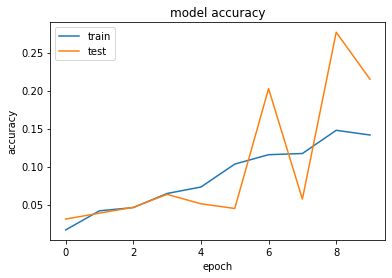

Train on 2587 samples, validate on 647 samples
Epoch 1/10
2587/2587 [==============================] - 0s 85us/step - loss: 1.0000 - mse: 1.0000 - accuracy: 0.0000e+00 - val_loss: 1.0000 - val_mse: 1.0000 - val_accuracy: 0.0000e+00
Epoch 2/10
2587/2587 [==============================] - 0s 48us/step - loss: 1.0000 - mse: 1.0000 - accuracy: 0.0000e+00 - val_loss: 1.0000 - val_mse: 1.0000 - val_accuracy: 0.0000e+00
Epoch 3/10
2587/2587 [==============================] - 0s 51us/step - loss: 1.0000 - mse: 1.0000 - accuracy: 0.0000e+00 - val_loss: 1.0000 - val_mse: 1.0000 - val_accuracy: 0.0000e+00
Epoch 4/10
2587/2587 [==============================] - 0s 48us/step - loss: 1.0000 - mse: 1.0000 - accuracy: 0.0000e+00 - val_loss: 1.0000 - val_mse: 1.0000 - val_accuracy: 0.0000e+00
Epoch 5/10
2587/2587 [==============================] - 0s 53us/step - loss: 1.0000 - mse: 1.0000 - accuracy: 0.0000e+00 - val_loss: 1.0000 - val_mse: 1.0000 - val_accuracy: 0.0000e+00
Epoch 6/10
2587/2587 [======

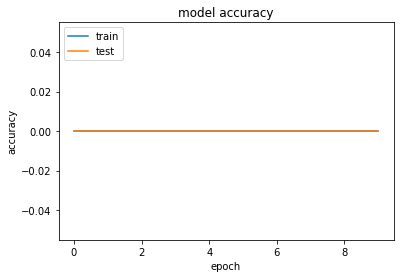

Train on 2587 samples, validate on 647 samples
Epoch 1/10
2587/2587 [==============================] - 0s 85us/step - loss: 1.0000 - mse: 1.0000 - accuracy: 0.0000e+00 - val_loss: 1.0000 - val_mse: 1.0000 - val_accuracy: 0.0000e+00
Epoch 2/10
2587/2587 [==============================] - 0s 53us/step - loss: 1.0000 - mse: 1.0000 - accuracy: 0.0000e+00 - val_loss: 1.0000 - val_mse: 1.0000 - val_accuracy: 0.0000e+00
Epoch 3/10
2587/2587 [==============================] - 0s 53us/step - loss: 1.0000 - mse: 1.0000 - accuracy: 0.0000e+00 - val_loss: 1.0000 - val_mse: 1.0000 - val_accuracy: 0.0000e+00
Epoch 4/10
2587/2587 [==============================] - 0s 56us/step - loss: 1.0000 - mse: 1.0000 - accuracy: 0.0000e+00 - val_loss: 1.0000 - val_mse: 1.0000 - val_accuracy: 0.0000e+00
Epoch 5/10
2587/2587 [==============================] - 0s 55us/step - loss: 1.0000 - mse: 1.0000 - accuracy: 0.0000e+00 - val_loss: 1.0000 - val_mse: 1.0000 - val_accuracy: 0.0000e+00
Epoch 6/10
2587/2587 [======

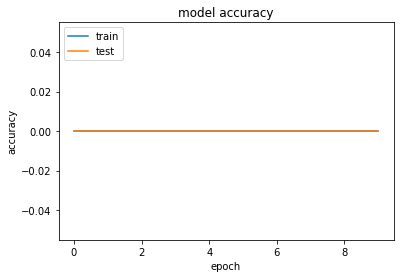

Train on 2587 samples, validate on 647 samples
Epoch 1/10
2587/2587 [==============================] - 0s 103us/step - loss: 1.0000 - mse: 1.0000 - accuracy: 0.0000e+00 - val_loss: 1.0000 - val_mse: 1.0000 - val_accuracy: 0.0000e+00
Epoch 2/10
2587/2587 [==============================] - 0s 68us/step - loss: 1.0000 - mse: 1.0000 - accuracy: 0.0000e+00 - val_loss: 1.0000 - val_mse: 1.0000 - val_accuracy: 0.0000e+00
Epoch 3/10
2587/2587 [==============================] - 0s 66us/step - loss: 1.0000 - mse: 1.0000 - accuracy: 0.0000e+00 - val_loss: 1.0000 - val_mse: 1.0000 - val_accuracy: 0.0000e+00
Epoch 4/10
2587/2587 [==============================] - 0s 56us/step - loss: 1.0000 - mse: 1.0000 - accuracy: 0.0000e+00 - val_loss: 1.0000 - val_mse: 1.0000 - val_accuracy: 0.0000e+00
Epoch 5/10
2587/2587 [==============================] - 0s 56us/step - loss: 1.0000 - mse: 1.0000 - accuracy: 0.0000e+00 - val_loss: 1.0000 - val_mse: 1.0000 - val_accuracy: 0.0000e+00
Epoch 6/10
2587/2587 [=====

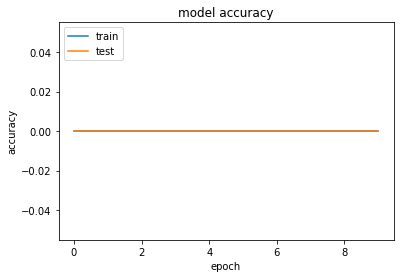

Train on 2587 samples, validate on 647 samples
Epoch 1/10
2587/2587 [==============================] - 0s 128us/step - loss: 0.2532 - mse: 0.2532 - accuracy: 0.7460 - val_loss: 0.0000e+00 - val_mse: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/10
2587/2587 [==============================] - 0s 62us/step - loss: 0.0630 - mse: 0.0630 - accuracy: 0.9362 - val_loss: 0.0000e+00 - val_mse: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/10
2587/2587 [==============================] - 0s 62us/step - loss: 0.0328 - mse: 0.0328 - accuracy: 0.9675 - val_loss: 0.0000e+00 - val_mse: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/10
2587/2587 [==============================] - 0s 60us/step - loss: 0.0206 - mse: 0.0206 - accuracy: 0.9795 - val_loss: 0.0000e+00 - val_mse: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/10
2587/2587 [==============================] - 0s 65us/step - loss: 0.0059 - mse: 0.0059 - accuracy: 0.9938 - val_loss: 0.0000e+00 - val_mse: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6/10
2587/2587 [=====

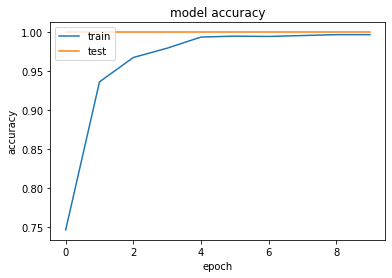

In [81]:
for model in models:
    history = model.fit(X_train, y_train, batch_size=32, validation_split = 0.2 ,epochs=10)
    model.evaluate(X_test, y_test, batch_size=16)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

## Overall Conclusion

It seems like the dataset is flawed because there's no date where there is a difference between high and low. 